In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
#from sklearn.cross_validation import train_test_split # LAE: deprecated naming!
from sklearn.model_selection import train_test_split
import random
import cPickle as pickle
%matplotlib inline
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)

np.random.seed(1337)
import keras

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Plotting settings ###
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2.5
plt.rcParams['xtick.labelsize']= 20
plt.rcParams['ytick.labelsize']= 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 7
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.minor.size'] = 8
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.edgecolor'] = 'black'

class snv():
    def __init__(self, norm_seq, hgvs, dbsnp, fasta, non_snv_seq, snv_genome_pos, rel_pos, snv_seq, strand, instruction,
                 snv_type, fragment_start, fragment_end):
        self.norm_seq = norm_seq
        self.hgvs = hgvs
        self.dbsnp = dbsnp
        self.fasta = fasta
        self.non_snv_seq = non_snv_seq
        self.snv_genome_pos = snv_genome_pos
        self.rel_pos = rel_pos
        self.snv_seq = snv_seq
        self.strand = strand
        self.instruction = instruction
        self.snv_type = snv_type
        self.fragment_start = fragment_start
        self.fragment_end = fragment_end
        self.show_change_seqs = []
        self.changed_seqs = []
        
    def __repr__(self):
        return 'Entry: {} \t {} \t {} \t {} \nNormal seq: {}'.format(self.hgvs, self.instruction, self.strand,
                                                                      self.snv_type, self.norm_seq)
    def __str__(self):
        return 'Entry: {} \t {} \t {} \t {} \nNormal seq: {}'.format(self.hgvs, self.instruction, self.strand,
                                                                      self.snv_type, self.norm_seq)

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    #df.loc[:,'obs_stab'] = test_df['stab_df']
    predictions = model.predict(test_seq).reshape(-1)
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Using TensorFlow backend.


### SNV data - includes phenotype, dbSNP, clnacc, etc. The predictions are from the retrained model.

In [3]:
df = pd.read_csv('./data/snv_phenotype_log_diff.csv')

In [4]:
print len(df)
sub = df[df['obs_diff'] != 0.0]
print len(sub)

# Select high quality data - average 30 reads per fraction
sub = sub[sub['total'] >= 620]
print len(sub)

path_list = ['Pathogenic', 'Likely pathogenic', 'Pathogenic, other', 'Pathogenic/Likely pathogenic']
benign_list = ['Benign/Likely benign', 'Benign', 'Likely Benign']
uncertain_list = ['Conflicting interpretations of pathogenicity', 'Uncertain significance']

path = sub[(sub['clin_sig'] == path_list[0]) | (sub['clin_sig'] == path_list[1]) |
           (sub['clin_sig'] == path_list[2]) | (sub['clin_sig'] == path_list[3])]
non = sub[(sub['clin_sig'] == benign_list[0]) | (sub['clin_sig'] == benign_list[1]) | (sub['clin_sig'] == benign_list[2])]
unsure = sub[(sub['clin_sig'] == uncertain_list[0]) | (sub['clin_sig'] == uncertain_list[1])]
#conflict = sub[sub['clin_sig'] == 'Conflicting interpretations of pathogenicity']


print 'Pathogen group: {}    Benign group: {}    Uncertain group: {}'.format(len(path), len(non), len(unsure))

3002
1996
1584
Pathogen group: 72    Benign group: 258    Uncertain group: 751


0.5531236123768031


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


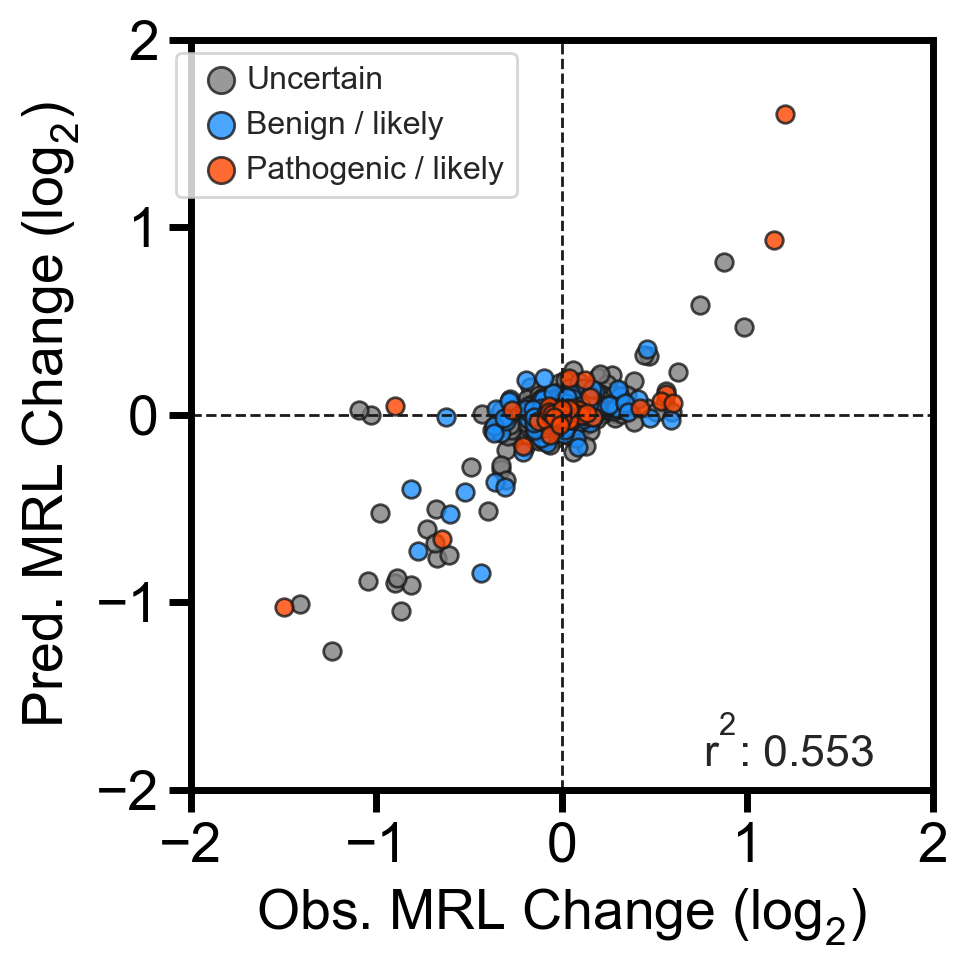

In [5]:
r_squared = r2(sub['log_pred_diff'], sub['log_obs_diff'])
print r_squared

f, ax = plt.subplots()
f.set_size_inches((5,5))
point_size = 40

ax.scatter(unsure['log_obs_diff'], unsure['log_pred_diff'], alpha=0.8, color='grey', label='Uncertain',
           linewidth=1, edgecolors='k', s=point_size)
ax.scatter(non['log_obs_diff'], non['log_pred_diff'], alpha=0.8, color='dodgerblue', label='Benign / likely',
           linewidth=1, edgecolors='k', s=point_size)
ax.scatter(path['log_obs_diff'], path['log_pred_diff'], alpha=0.8, color='orangered', label='Pathogenic / likely',
           linewidth=1, edgecolors='k', s=point_size)

ax.set_ylabel('Pred. MRL Change (log$_2$)')
ax.set_xlabel('Obs. MRL Change (log$_2$)')
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
ax.set_xticks(range(-2,3))
ax.set_yticks(range(-2,3))
ax.hlines(y=0,xmin=-2, xmax=2, linestyles='dashed', linewidth=1)
ax.vlines(x=0,ymin=-2, ymax=2, linestyles='dashed', linewidth=1)
ax.text(x=0.69, y=0.03, s='r$^2$: ' + str(round(r_squared, 3)), transform=ax.transAxes, size=16)
ax.legend(loc=(-0.02,0.79), handletextpad=-0.2, fontsize=11.5)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')